# **-------------- Classification ---------------**

In [ ]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Logger is now configured correctly.")


2025-05-08 15:46:16,443 - INFO - Logger is now configured correctly.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

logger.info("All libraries for Classification imported successfully.")


2025-05-08 15:44:22,102 - INFO - All libraries for Classification imported successfully.


## **Data Cleaning**

In [ ]:
df = pd.read_csv("/content/clinically_validated_balanced_disease_data.csv")

logger.info("Data has been read from CSV file.")

2025-05-08 15:44:22,382 - INFO - Data has been read from CSV file.


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 36 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Gender                                            30000 non-null  object 
 1   Age                                               30000 non-null  int64  
 2   Hemoglobin (g/dL)                                 30000 non-null  float64
 3   RBC (million/µL)                                  30000 non-null  float64
 4   Platelet Count (platelets/µL)                     30000 non-null  float64
 5   Fasting Blood Sugar (mg/dL)                       30000 non-null  float64
 6   Hemoglobin A1C (%)                                30000 non-null  float64
 7   Serum Creatinine (mg/dL)                          30000 non-null  float64
 8   Blood Urea Nitrogen (BUN) (mg/dL)                 30000 non-null  float64
 9   Glomerular Filtra

Remove duplicates

In [ ]:
duplicate_count = df.duplicated().sum()
print(f"Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

Found 0 duplicate rows.


Label encoding

In [ ]:
gender_mapping = {'Men': 0, 'Women': 1, 'Children': 2}
df['Gender'] = df['Gender'].map(gender_mapping)

In [ ]:
protein_glucose_mapping = {'Absent': 0, 'Trace': 1}
df['Urine Protein'] = df['Urine Protein'].map(protein_glucose_mapping)
df['Urine Glucose'] = df['Urine Glucose'].map(protein_glucose_mapping)

Remove nulls

In [ ]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [ ]:
df.head(10)

,Gender,Age,Hemoglobin (g/dL),RBC (million/µL),Platelet Count (platelets/µL),Fasting Blood Sugar (mg/dL),Hemoglobin A1C (%),Serum Creatinine (mg/dL),Blood Urea Nitrogen (BUN) (mg/dL),Glomerular Filtration Rate (GFR) (mL/min/1.73m²),...,Troponin I (ng/mL),Albumin (g/dL),Globulin (g/dL),Albumin/Globulin Ratio,Diabetes,Anemia,Kidney Failure,Liver Failure,Ischimic Heart Disease,Calculated_GFR
0,1,29,10.398541,3.889963,50000.000000,54.849320,15.679801,0.414540,20.869253,133.308737,...,45.622155,4.627089,5.000000,1.356867,1,1,0,1,1,139.108258
1,2,15,11.635297,3.108103,401869.129231,105.187236,4.106361,0.748471,7.328063,83.612196,...,15.402630,3.997586,1.440028,2.776048,0,1,1,0,1,87.433730
2,1,62,10.963727,3.469249,423128.190300,62.697532,4.413461,0.329326,7.582793,117.492256,...,0.011467,2.166290,1.378128,1.571908,1,1,0,0,1,119.003180
3,0,24,29.180714,3.904182,155688.012819,83.824602,4.198131,0.721934,20.405932,133.500291,...,0.037137,2.809392,1.377815,2.039020,1,0,0,0,1,130.422429
4,1,74,27.462987,4.011334,50000.000000,66.463493,4.094548,0.198991,15.656402,129.958325,...,0.008401,5.393931,4.083586,2.000566,0,0,0,0,1,129.101865
5,1,64,13.781182,4.472466,50000.000000,245.434554,5.100817,0.181550,23.620751,145.208453,...,0.000000,2.511655,4.777149,0.925703,1,1,0,0,0,142.740225
6,1,61,14.375081,3.755733,119520.742045,69.013255,4.917266,0.806817,20.374181,80.719490,...,0.000000,5.631692,5.000000,1.999530,0,1,1,1,0,78.759563
7,1,61,6.769819,5.121238,72099.021036,383.846462,4.910897,0.748777,5.675517,83.556304,...,0.000000,2.038332,4.973679,0.716947,1,1,1,1,1,86.199043
8,1,78,13.656177,2.195746,330487.693498,84.274555,11.482921,0.427746,56.607658,94.744520,...,0.000000,5.647695,3.266952,1.728735,1,1,0,0,0,97.585503
9,0,61,9.987109,8.086329,310333.645411,90.815428,4.303904,1.321368,6.631614,57.023055,...,0.000000,5.959894,1.423267,4.187475,0,1,1,0,1,57.741060


Splitting Data (Early Splitting to avoid data Leakage)

In [ ]:
# Log before splitting
logger.info("Data is cleaned. Proceeding to train-test split...")

target_columns = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischimic Heart Disease']
X = df.drop(columns=target_columns)
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:44:22,592 - INFO - Data is cleaned. Proceeding to train-test split...
2025-05-08 15:44:22,605 - INFO - Data has been split into training and testing sets.


Handeling Outliers

In [ ]:
for col in X_train.columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)
logger.info("Outliers are removed from Train data")

2025-05-08 15:44:22,741 - INFO - Outliers are removed from Train data


#### Feature Selection

In [ ]:
mi_scores = pd.DataFrame({target: mutual_info_classif(X_train, y_train[target], discrete_features=False) for target in target_columns}, index=X_train.columns)
mi_scores["Average_Score"] = mi_scores.mean(axis=1)
selected_features = mi_scores[mi_scores["Average_Score"] >= 0.001].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

logger.info("Important Features are Selected")

2025-05-08 15:44:46,494 - INFO - Important Features are Selected


#### Feature Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

logger.info("Features are Scaled")

2025-05-08 15:44:46,516 - INFO - Features are Scaled


#### Data visualization Before Scaling

<Figure size 1600x1000 with 0 Axes>

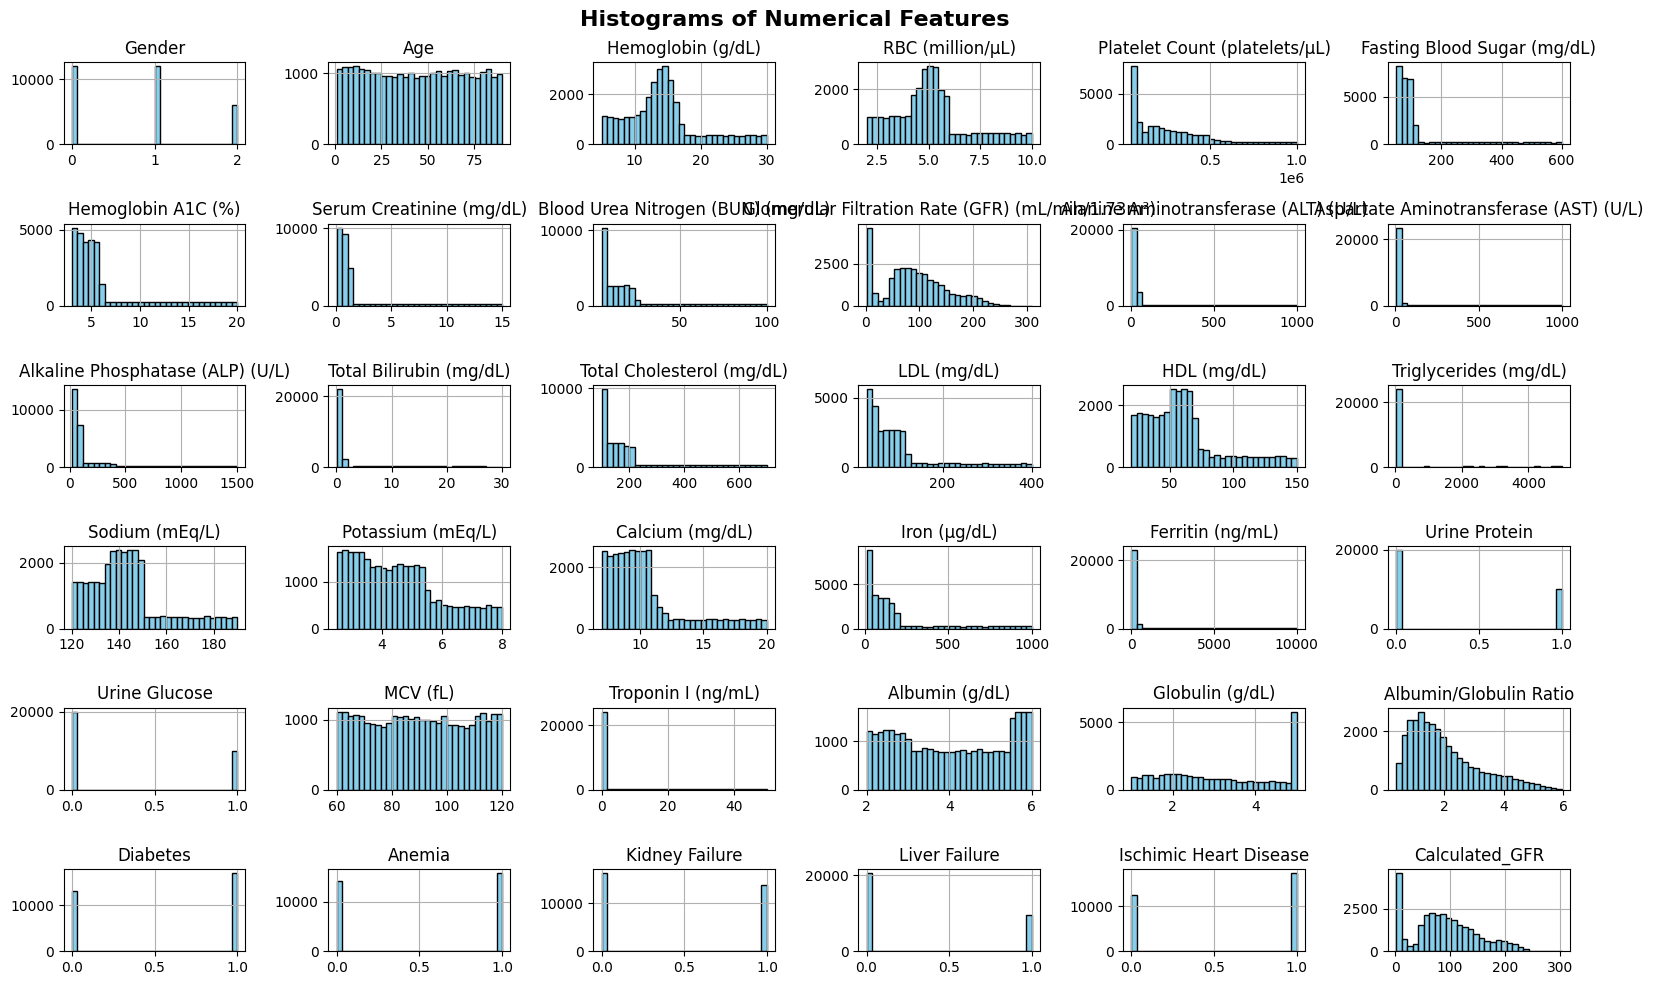

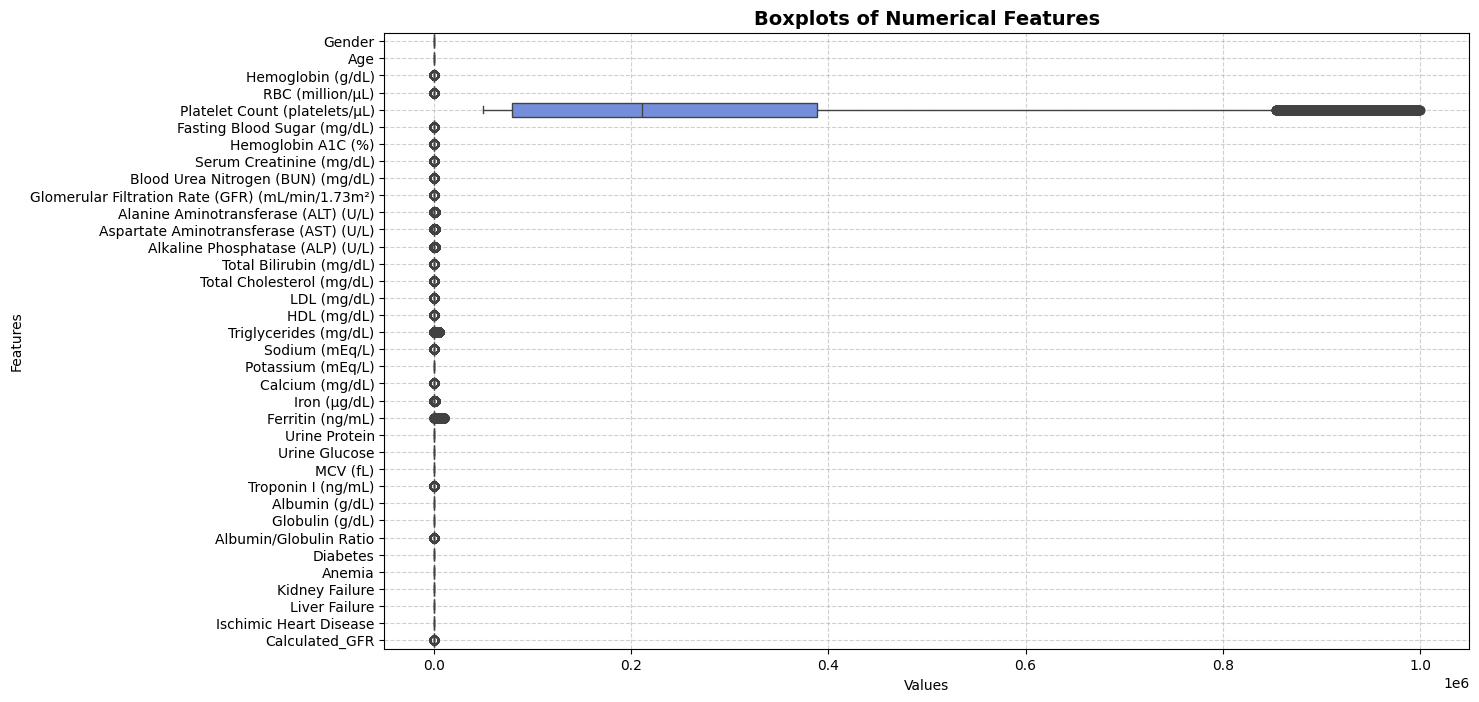

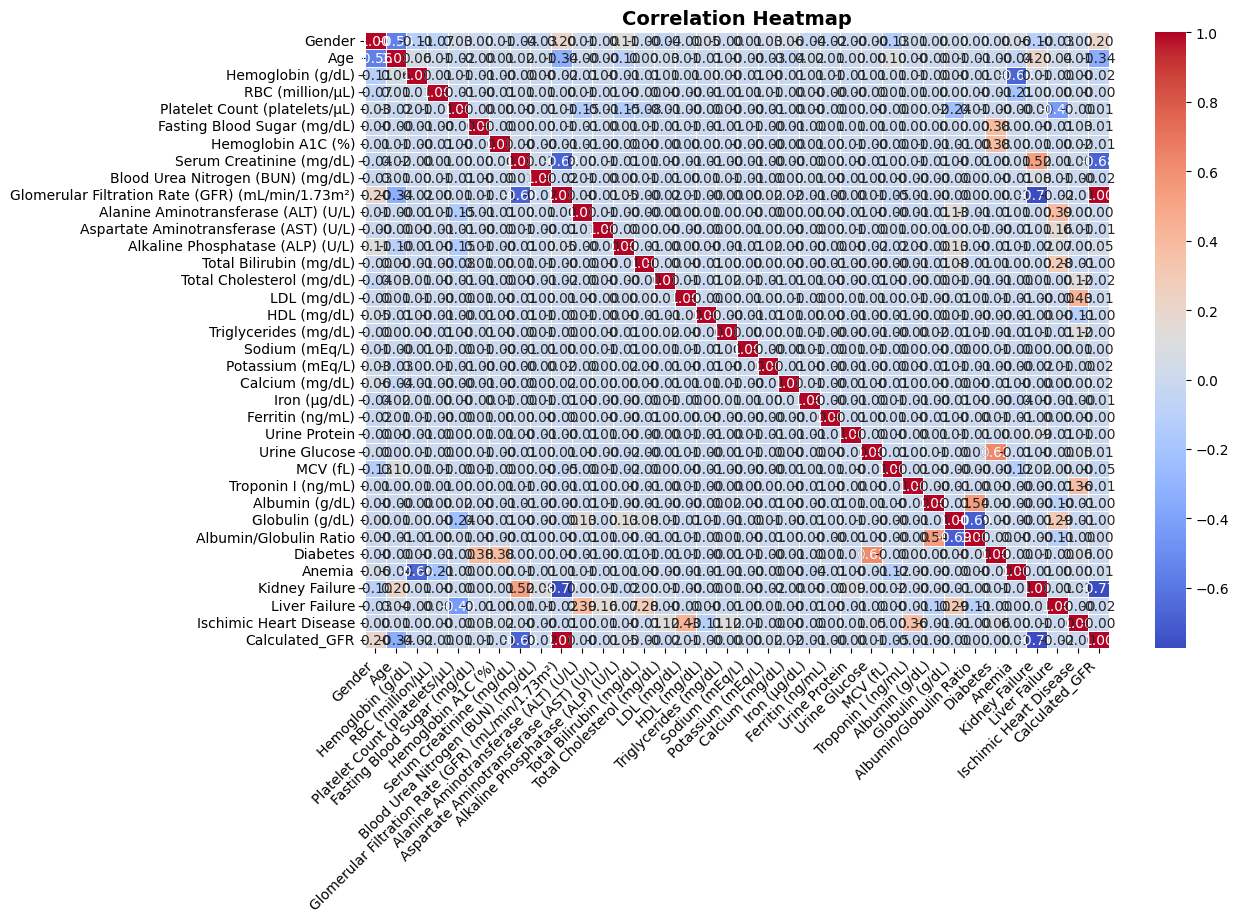

In [ ]:
num_df = df.select_dtypes(include=['number'])

#histograms
plt.figure(figsize=(16, 10))
num_df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=num_df, orient='h', palette="coolwarm")
plt.title("Boxplots of Numerical Features", fontsize=14, fontweight='bold')
plt.xlabel("Values")
plt.ylabel("Features")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#heatmap
plt.figure(figsize=(12, 8))
corr_matrix = num_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

#### Data Visualization After Scaling

<Figure size 1600x1000 with 0 Axes>

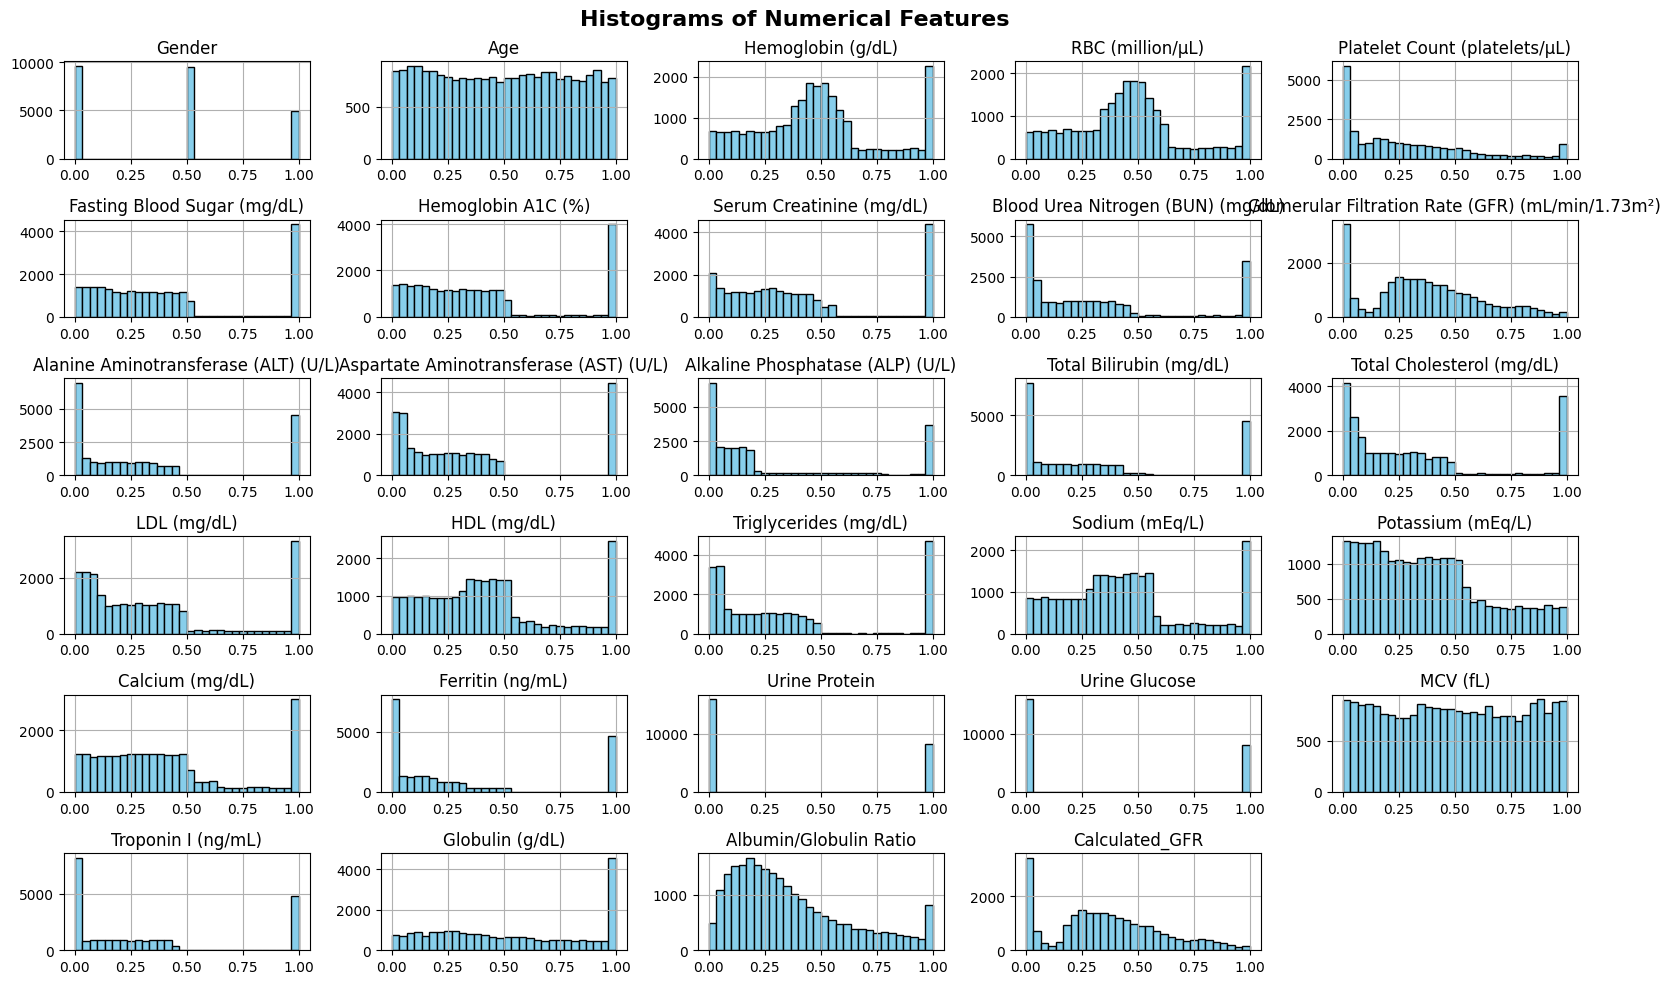

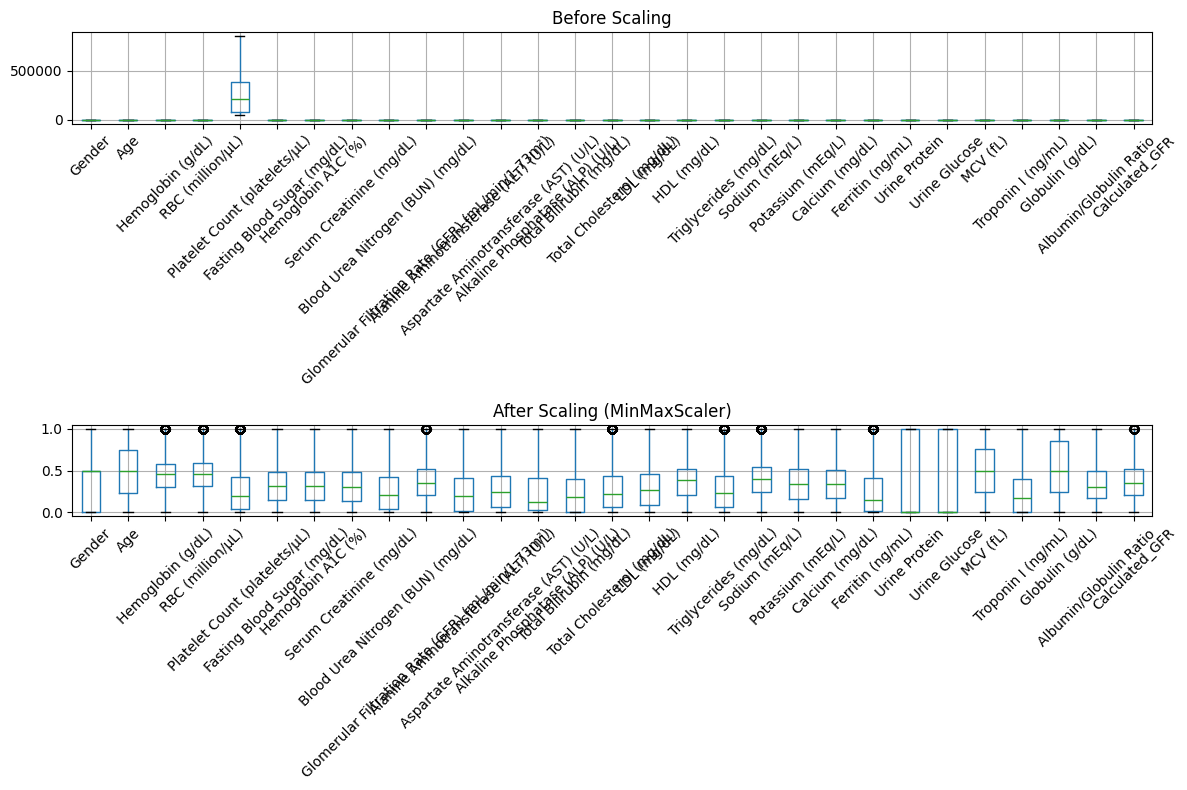

In [ ]:
num_df = X_train_scaled.select_dtypes(include=['number'])

plt.figure(figsize=(16, 10))
num_df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (MinMaxScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

# **---------------- Progression ----------------**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger.info("All libraries for Progression imported successfully.")

2025-05-08 15:45:05,028 - INFO - All libraries for Progression imported successfully.


## **Anemia_progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/anemia_progression_dataset.csv")

# Encode gender
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Cap outliers (IQR method)
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

# Save cleaned dataset
output_file = "cleaned_tests_Anemia.csv"
df.to_csv(output_file, index=False)
print(f"Cleaned data saved to {output_file}")

df.head(10)

Cleaned data saved to cleaned_tests_Anemia.csv


,Age,Gender,Total Iron Binding Capacity (TIBC),Vitamin B12,Folate,Reticulocyte Count,Disease Progression (%)
0,22,1,302.689212,1244.381992,18.771425,1.094828,65.941887
1,70,1,483.040430,430.902114,5.292467,0.887291,0.000000
2,2,0,181.769516,1030.914164,6.677651,1.125602,24.960797
3,35,1,306.256913,487.789095,7.749201,0.519651,0.000000
4,26,1,334.232438,1298.717058,16.054020,2.461642,74.551560
5,72,1,292.391812,1505.217310,4.737705,1.032268,62.211678
6,30,0,287.119267,124.405559,11.100393,0.767449,30.546073
7,26,1,292.334165,256.506313,19.686166,1.418414,0.000000
8,36,1,138.444133,1167.648034,19.719053,0.622863,45.104580
9,35,1,400.209786,1952.530861,9.877727,0.666280,75.741484


### Correlation Heatmaps Before Splitting

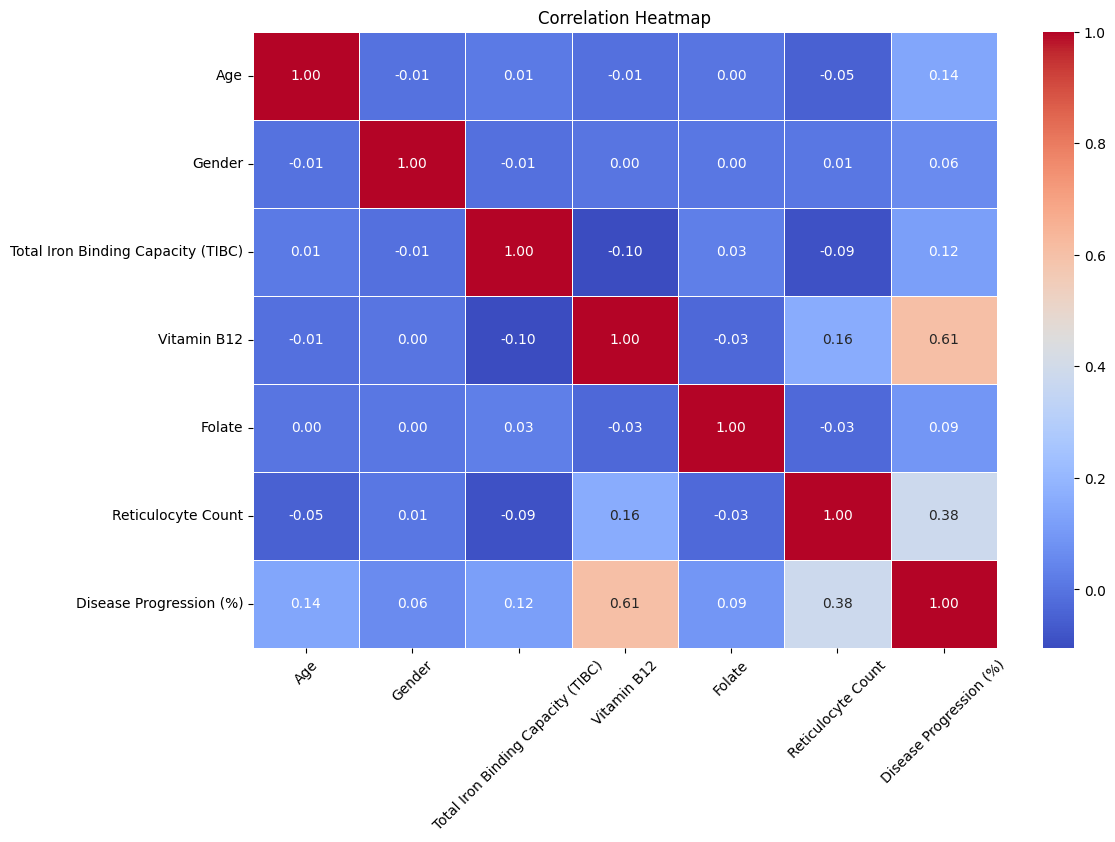

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train test Split

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:45:05,657 - INFO - Data has been split into training and testing sets.


### Min-Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:45:05,675 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

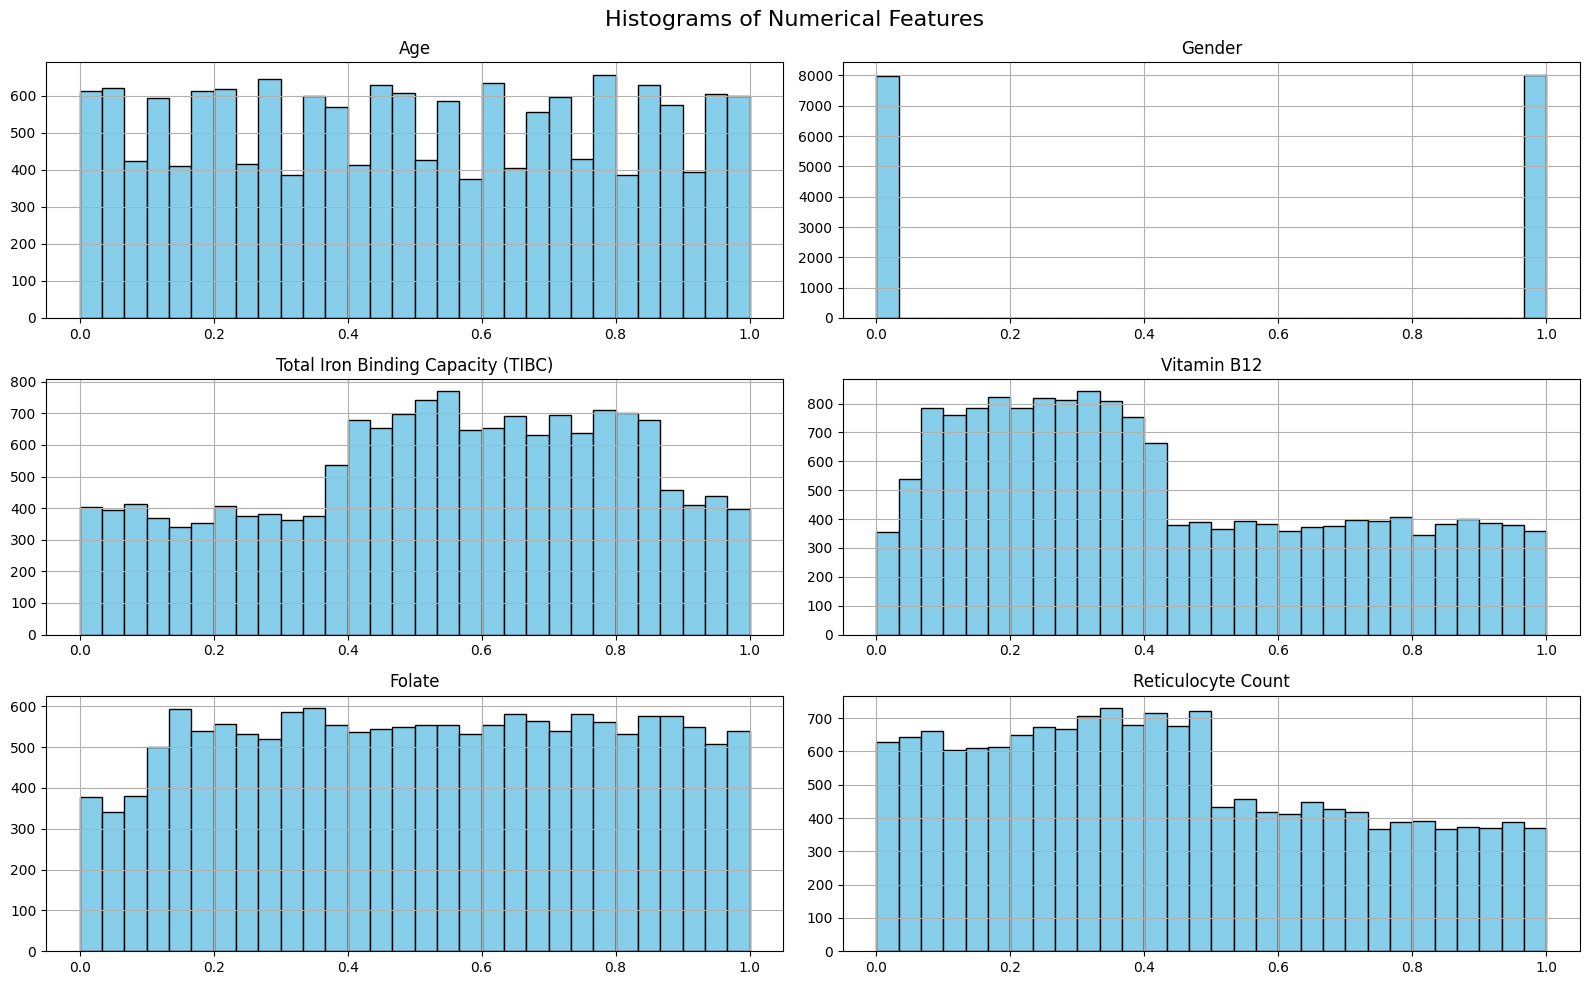

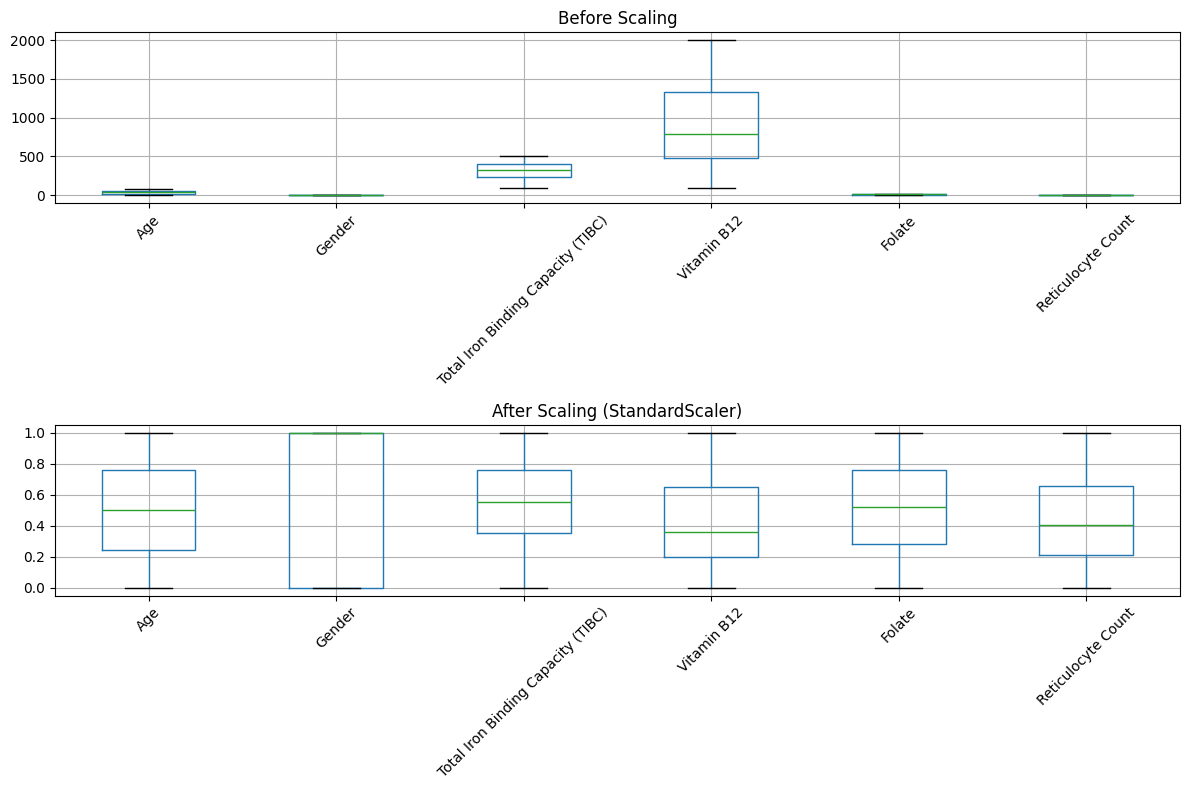

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

## **Diabetes_progression**

### Data Cleaning

In [ ]:
# Load dataset
df = pd.read_csv("/content/diabetes_progression_dataset_with_classification.csv")
print(df.info())
print(df.head())

# Label encoding
label_maps = {
    'Gender': {'Male': 0, 'Female': 1},
    'Diabetes Type': {'No Diabetes': 0, 'Type 1': 1, 'Type 2': 2}
}
for col, mapping in label_maps.items():
    df[col] = df[col].map(mapping)

# Remove nulls
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove duplicates
duplicates = df.duplicated().sum()
print(f"Found {duplicates} duplicate rows.")
df.drop_duplicates(inplace=True)

# Cap outliers
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

# Save cleaned data
df.to_csv("cleaned_diabetes_dataset.csv", index=False)
print("Cleaned data saved.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 20000 non-null  int64  
 1   Gender                              20000 non-null  object 
 2   Oral Glucose Tolerance Test (OGTT)  20000 non-null  float64
 3   C-Peptide                           20000 non-null  float64
 4   Microalbuminuria (Urine Albumin)    20000 non-null  float64
 5   Disease Progression (%)             20000 non-null  float64
 6   Diabetes Type                       20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.1+ MB
None
   Age    Gender  Oral Glucose Tolerance Test (OGTT)  C-Peptide  \
0   13  Children                          229.801337   0.353615   
1   41      Male                          103.728608   1.285470   
2   39      Male                       

### Correlation Heatmaps before splitting

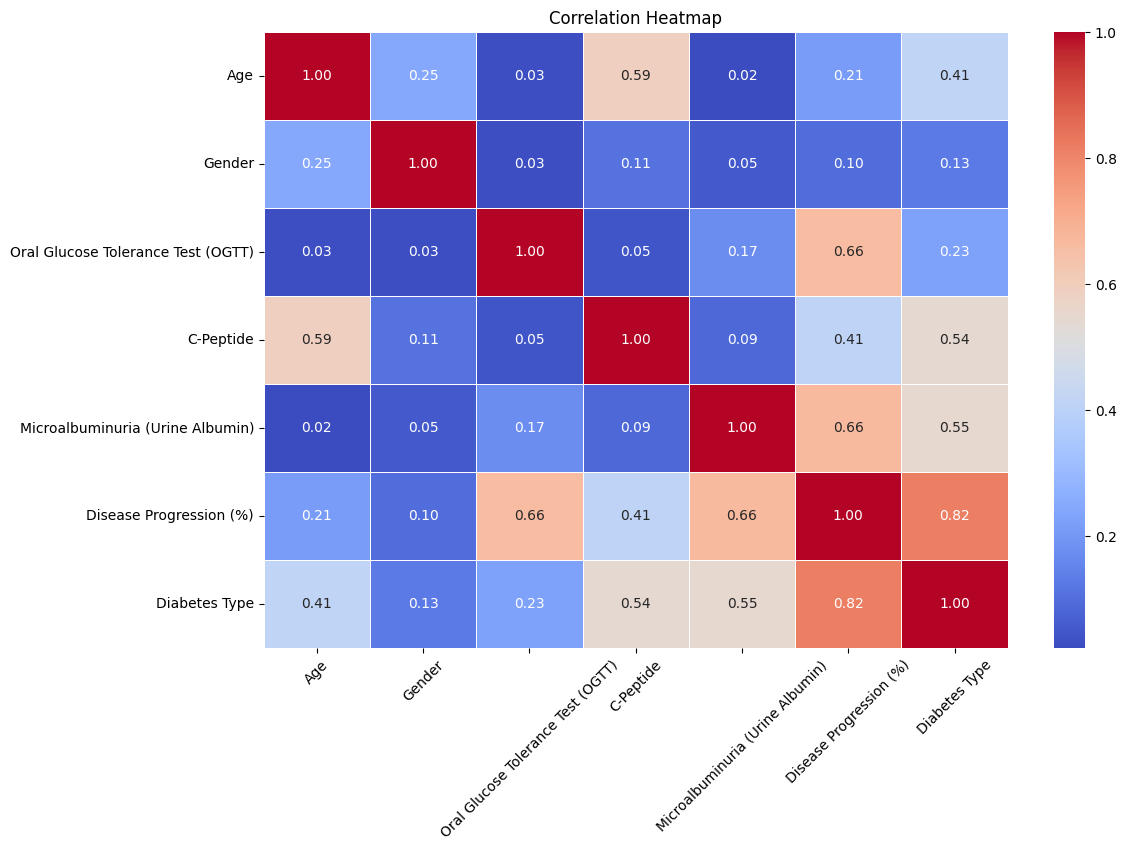

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
# Separate features and targets
X = df.drop(['Disease Progression (%)', 'Diabetes Type'], axis=1)
y_reg = df['Disease Progression (%)']
y_cls = df['Diabetes Type']

# Split
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(X, y_reg, y_cls, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:45:11,079 - INFO - Data has been split into training and testing sets.


### Min-Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logger.info("Features are Scaled")

2025-05-08 15:45:11,102 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

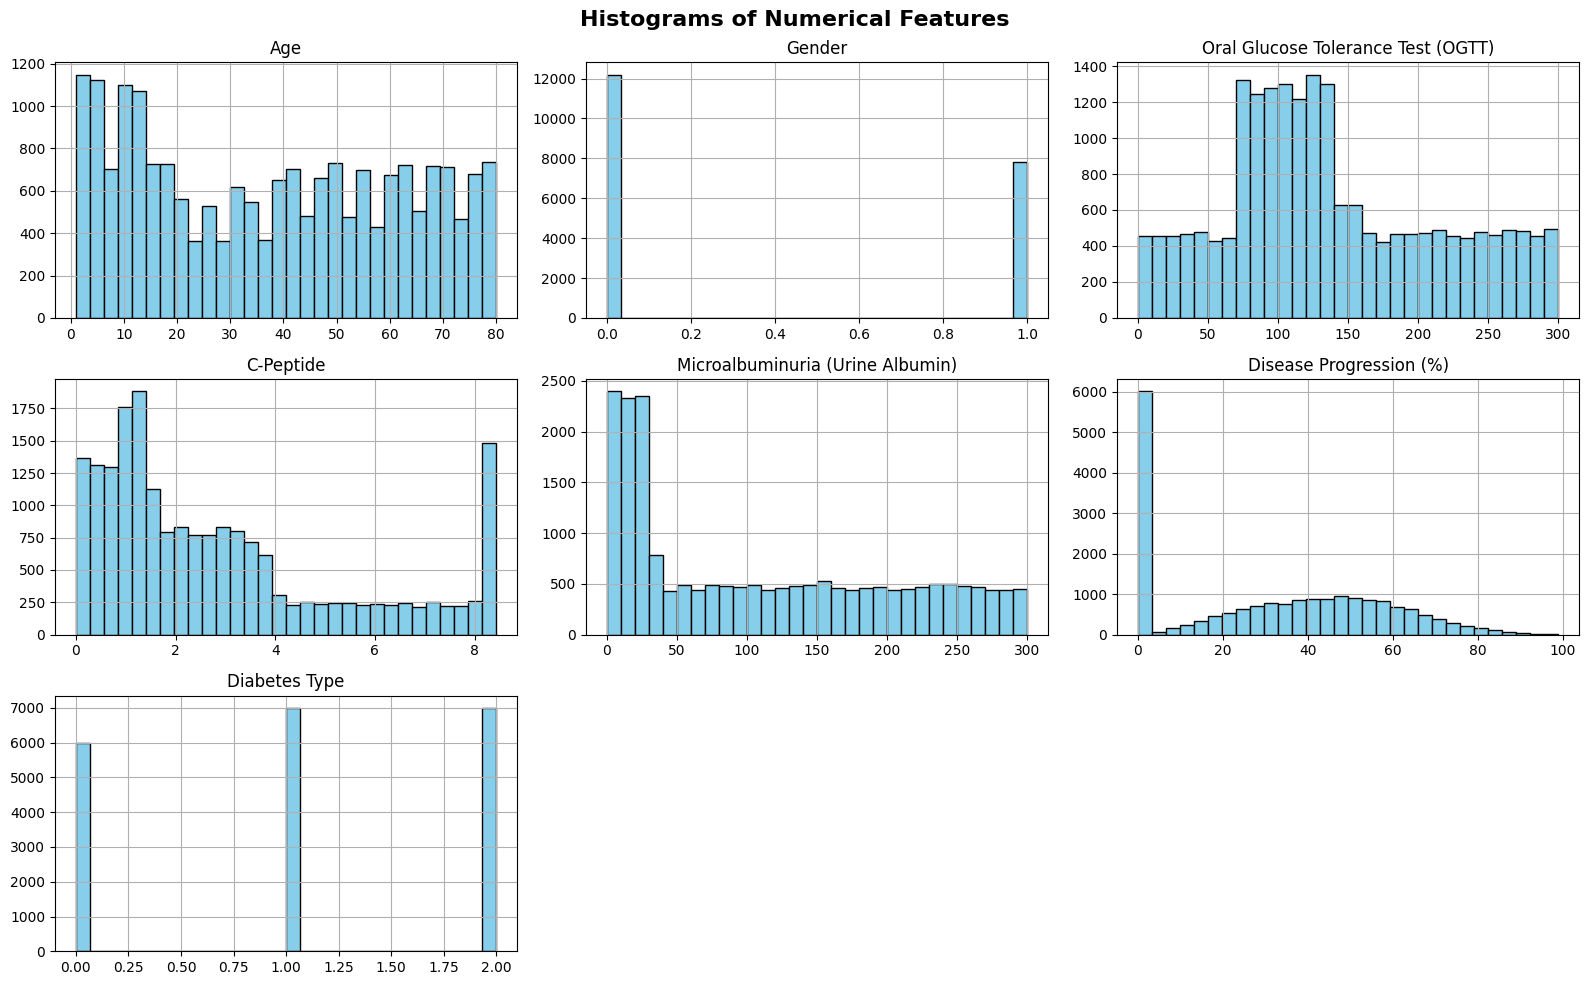

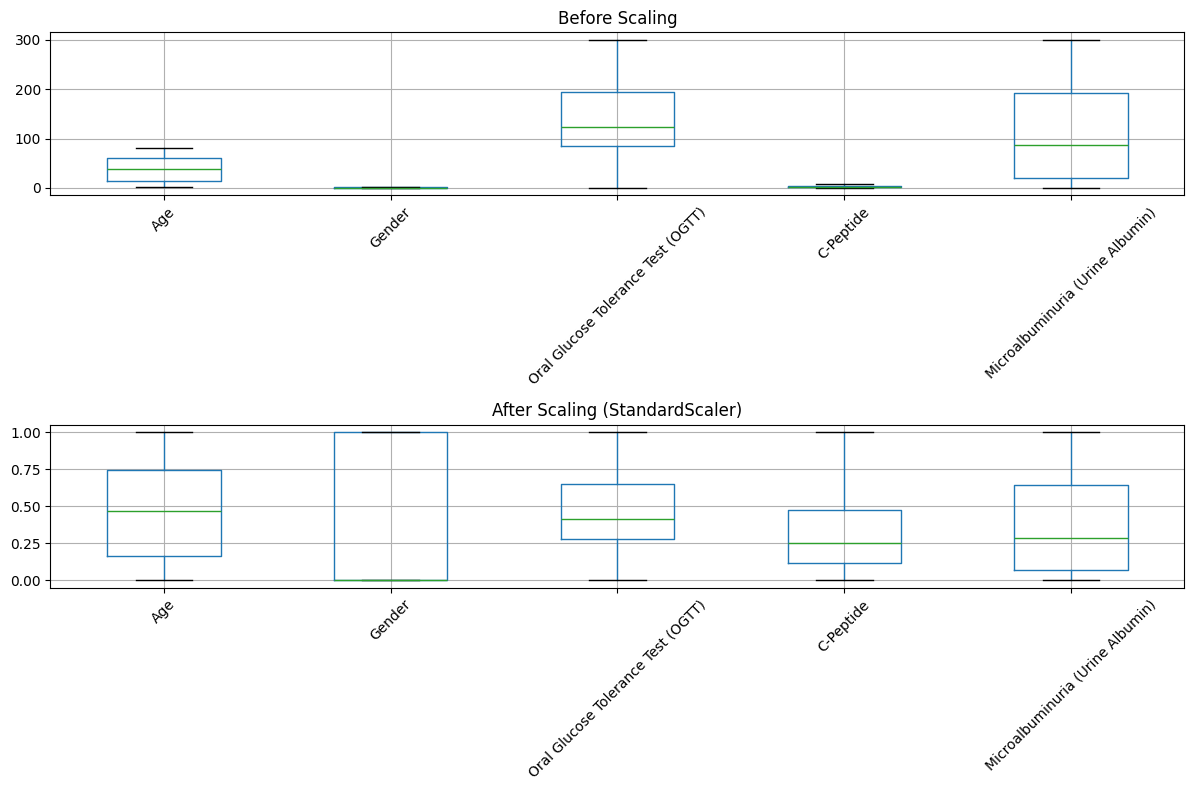

In [ ]:
# Histogram
plt.figure(figsize=(16, 10))
df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
scaledframe = pd.DataFrame(X_train_scaled, columns=X_train.columns) # Converting to df for visualization
scaledframe.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

## **Kidney_disease Progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/kidney_disease_progression_dataset.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Kidney).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               20000 non-null  int64  
 1   Gender                            20000 non-null  object 
 2   24-hour Urine Protein             20000 non-null  float64
 3   Serum Uric Acid                   20000 non-null  float64
 4   Serum Creatinine                  20000 non-null  float64
 5   Glomerular Filtration Rate (GFR)  20000 non-null  float64
 6   Blood Urea Nitrogen (BUN)         20000 non-null  float64
 7   Disease Progression (%)           20000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.2+ MB
None
   Age  Gender  24-hour Urine Protein  Serum Uric Acid  Serum Creatinine  \
0   35  Female             510.974002        11.696598          9.384053   
1   24  Female              92.690168      

### Heatmaps for ther whole dataset before splitting

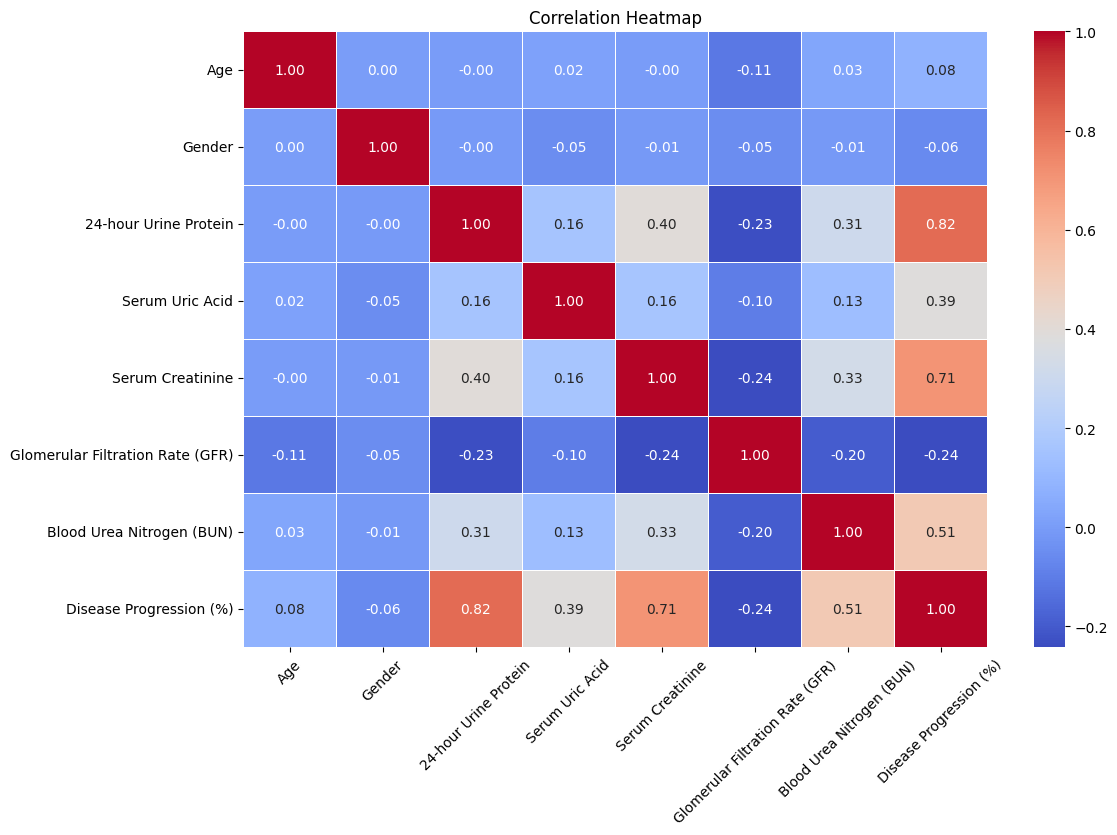

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")


2025-05-08 15:45:14,749 - INFO - Data has been split into training and testing sets.


### Min_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:45:14,766 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

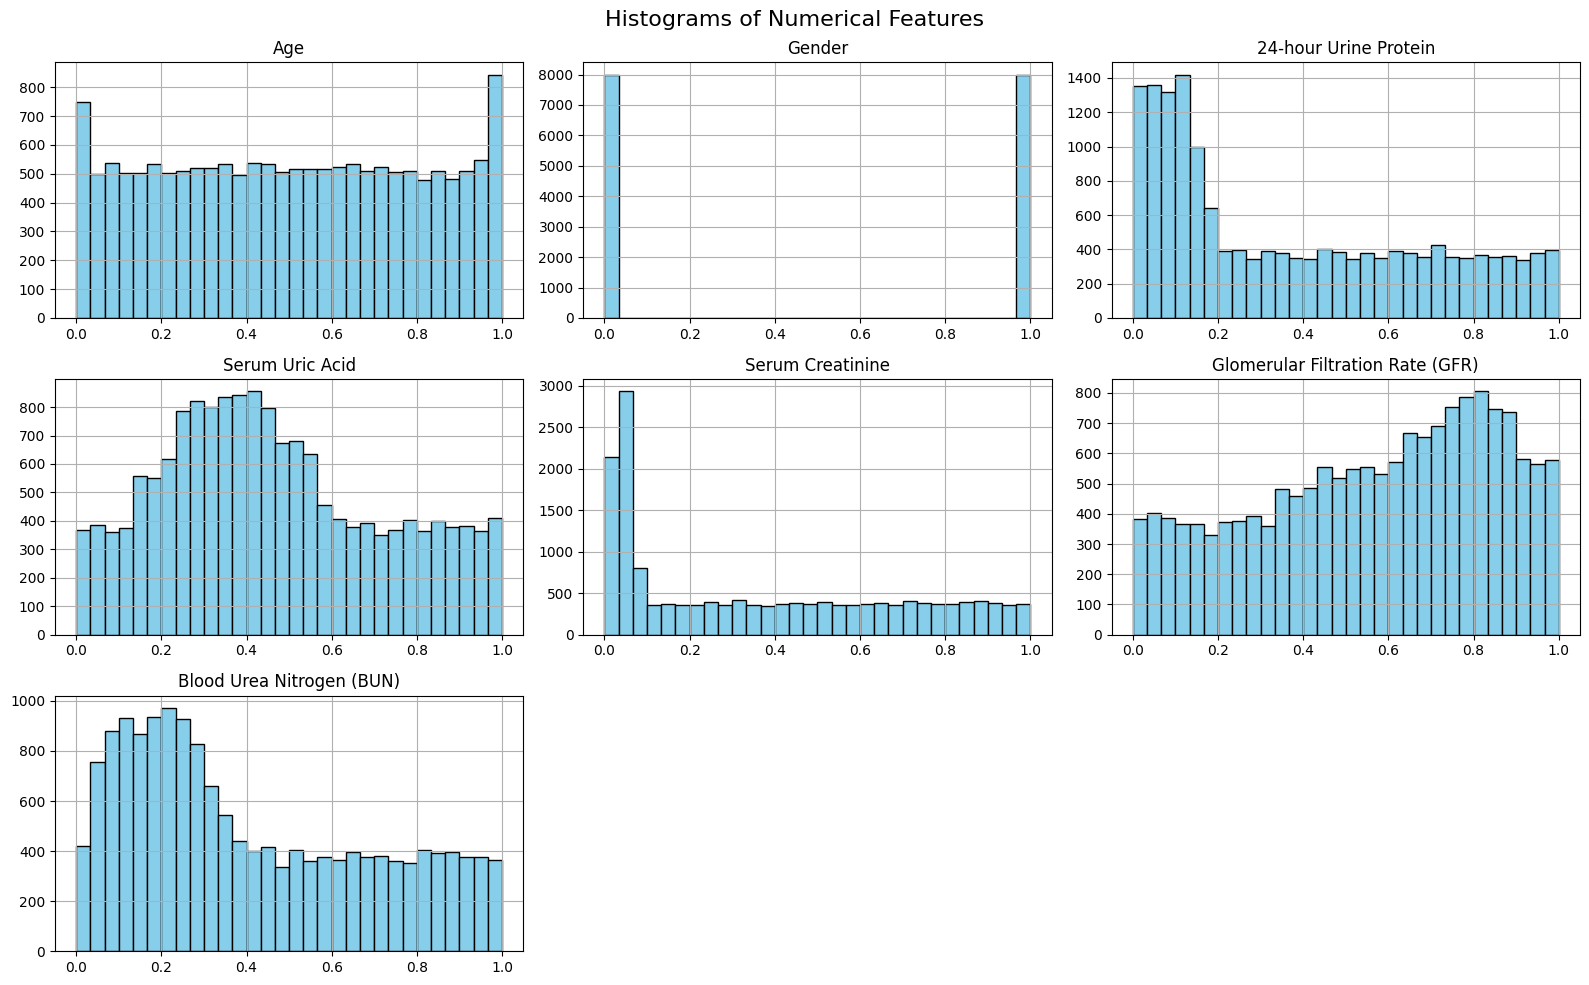

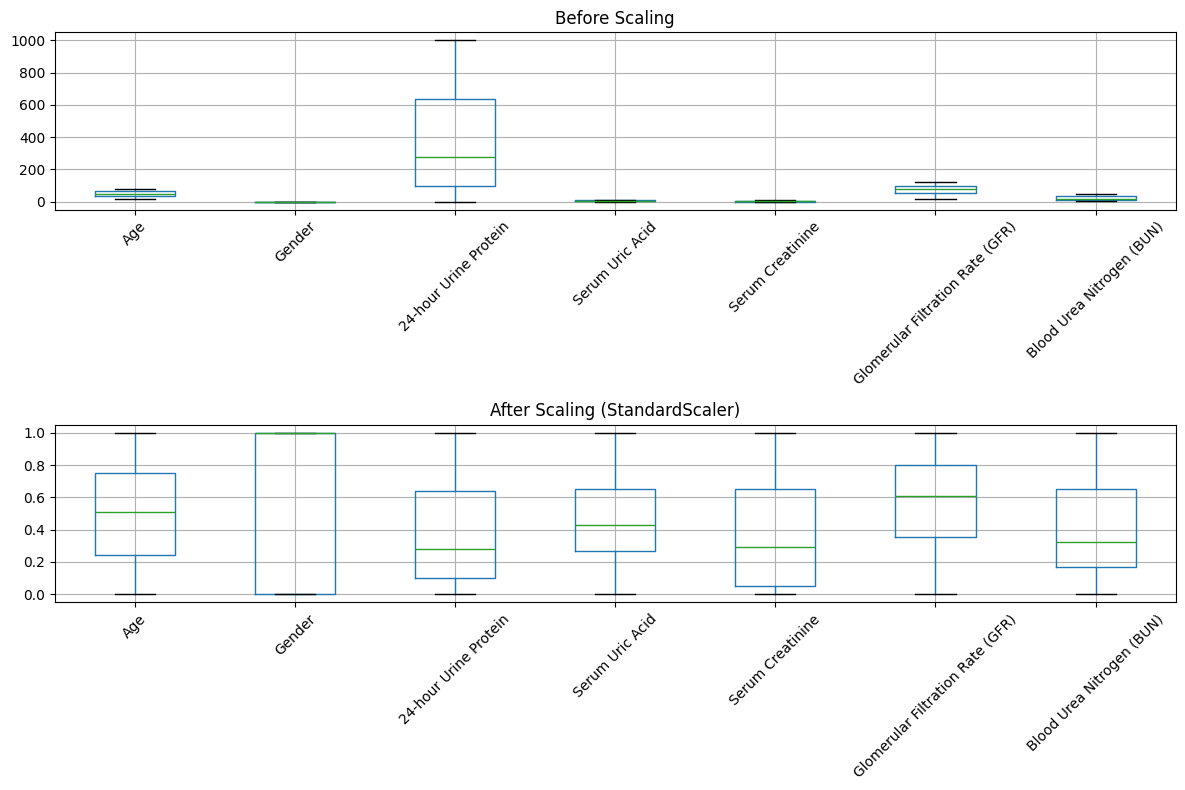

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

## **liver_disease Progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/liver_disease_progression_dataset_with_child_gender.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Liver).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   20000 non-null  object 
 1   Age                      20000 non-null  int64  
 2   PT_INR                   20000 non-null  float64
 3   GGT                      20000 non-null  float64
 4   Ammonia                  20000 non-null  float64
 5   Bilirubin                20000 non-null  float64
 6   Albumin                  20000 non-null  float64
 7   Creatinine               20000 non-null  float64
 8   ALT                      20000 non-null  float64
 9   AST                      20000 non-null  float64
 10  Platelet_Count           20000 non-null  float64
 11  Disease Progression (%)  20000 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.8+ MB
None
   Gender  Age    PT_INR        GGT    Ammonia  Bilirubin   Albumin

### Heatmaps for the whole dataset

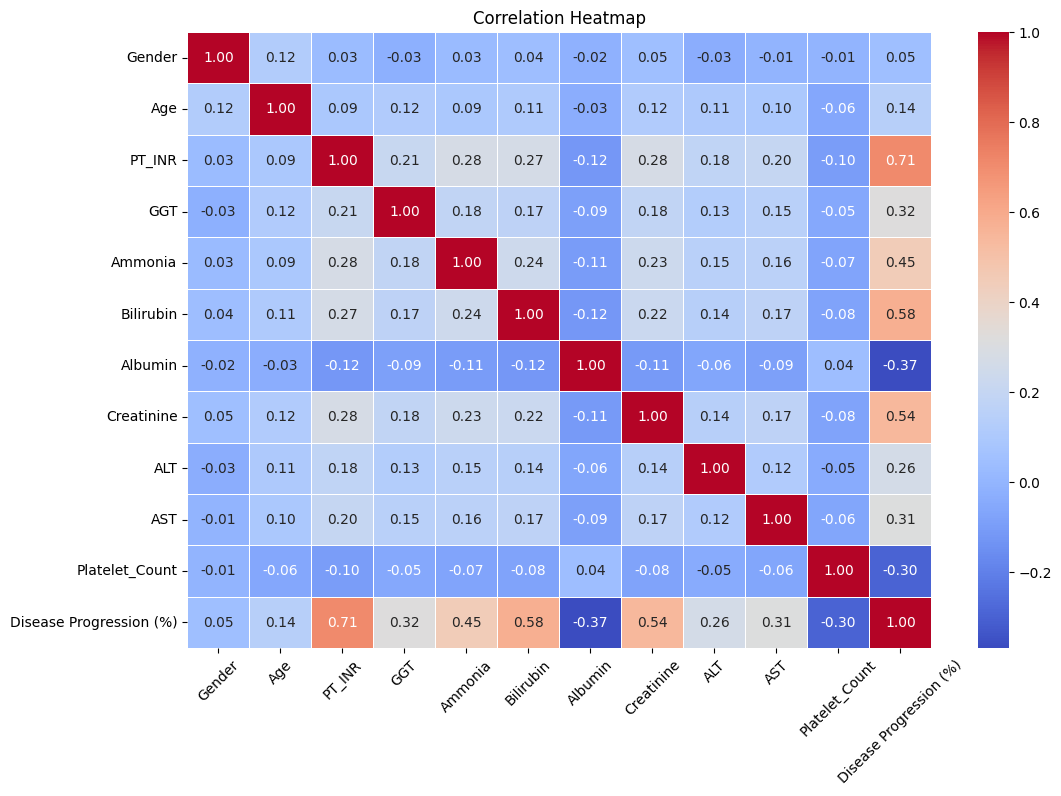

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:45:18,062 - INFO - Data has been split into training and testing sets.


### Mini_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:45:18,084 - INFO - Features are Scaled


### Data Visualization

<Figure size 1600x1000 with 0 Axes>

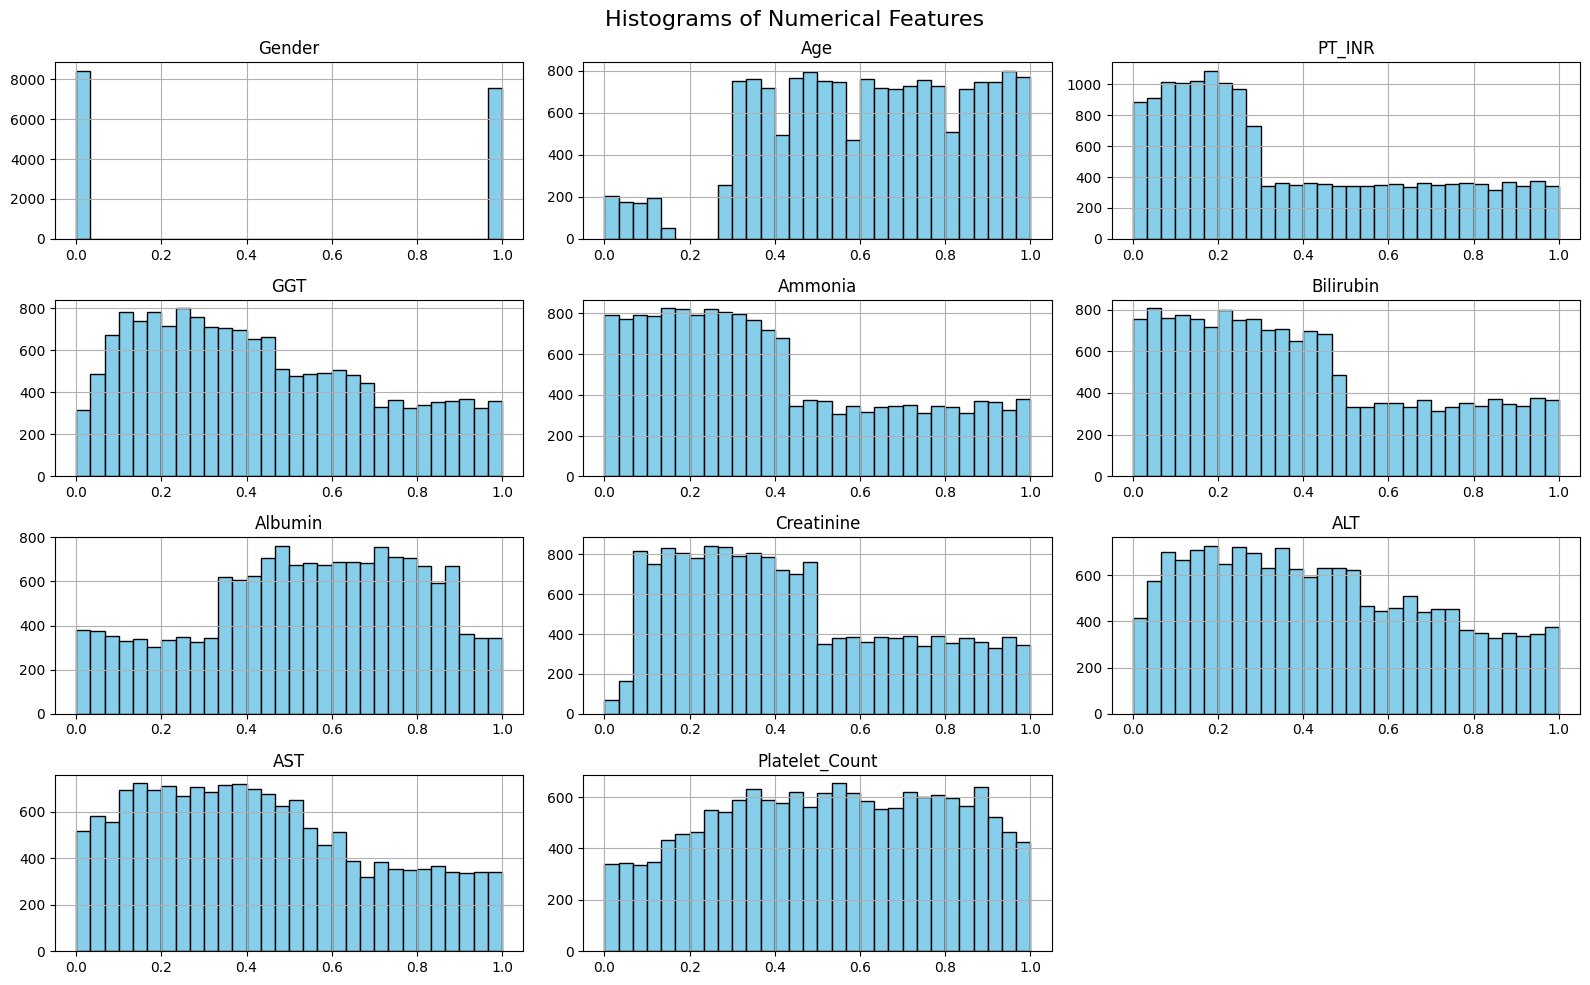

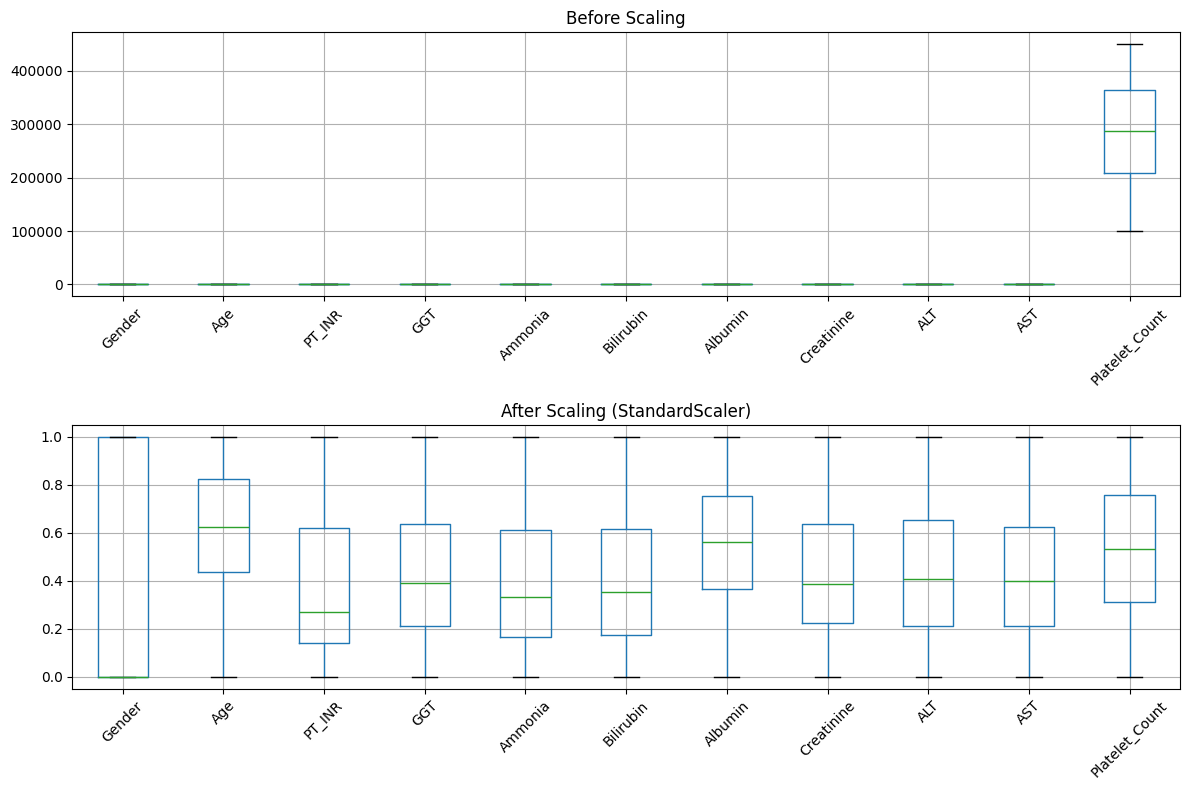

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

## **Heart_disease**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/Heart_Disease_progression_dataset_with_child_gender.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Heart).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     20000 non-null  int64  
 1   Gender                                  20000 non-null  object 
 2   LDL                                     20000 non-null  float64
 3   HDL                                     20000 non-null  float64
 4   Triglycerides                           20000 non-null  float64
 5   CRP                                     20000 non-null  float64
 6   ECG                                     20000 non-null  int64  
 7   Blood Pressure                          20000 non-null  float64
 8   Cholesterol                             20000 non-null  float64
 9   Troponin                                20000 non-null  float64
 10  BNP                                     20000 non-null  fl

### Heat Maps for the whole dataset

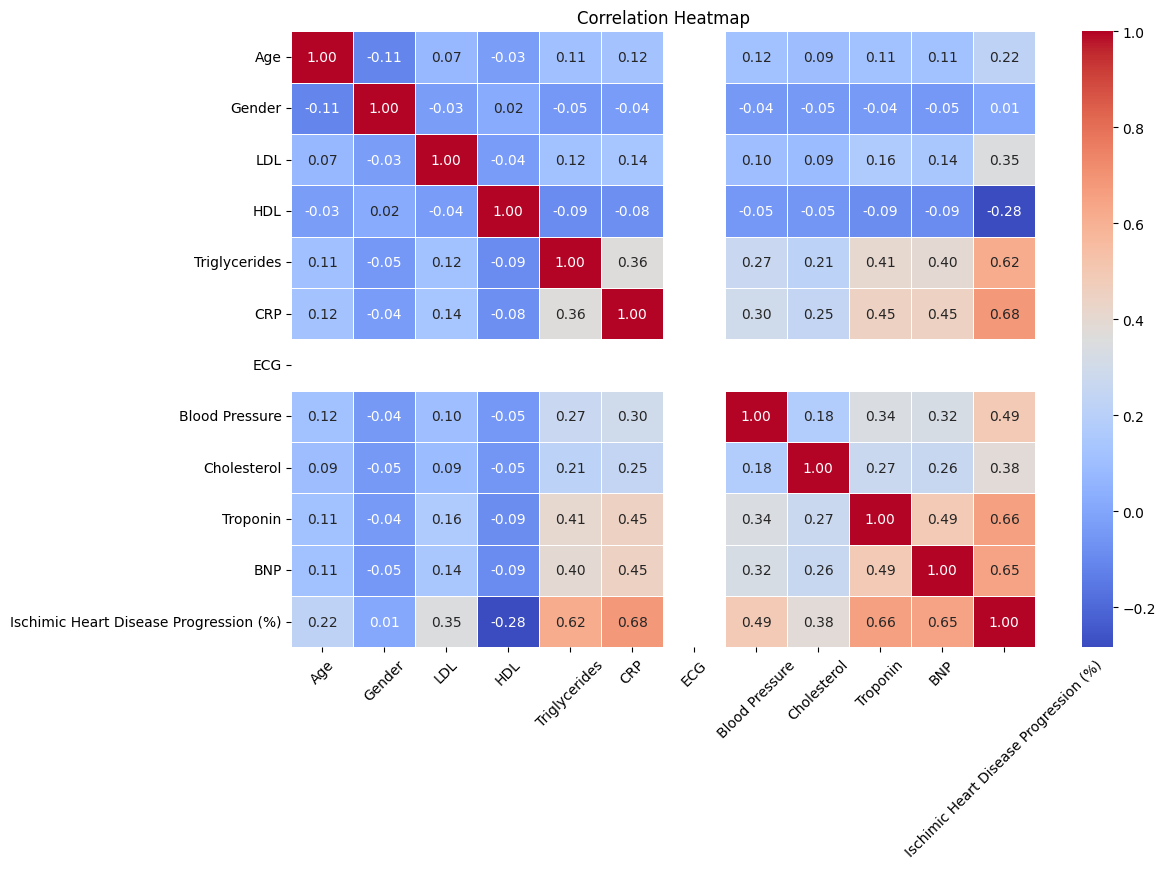

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:45:22,426 - INFO - Data has been split into training and testing sets.


### Min_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:45:22,446 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

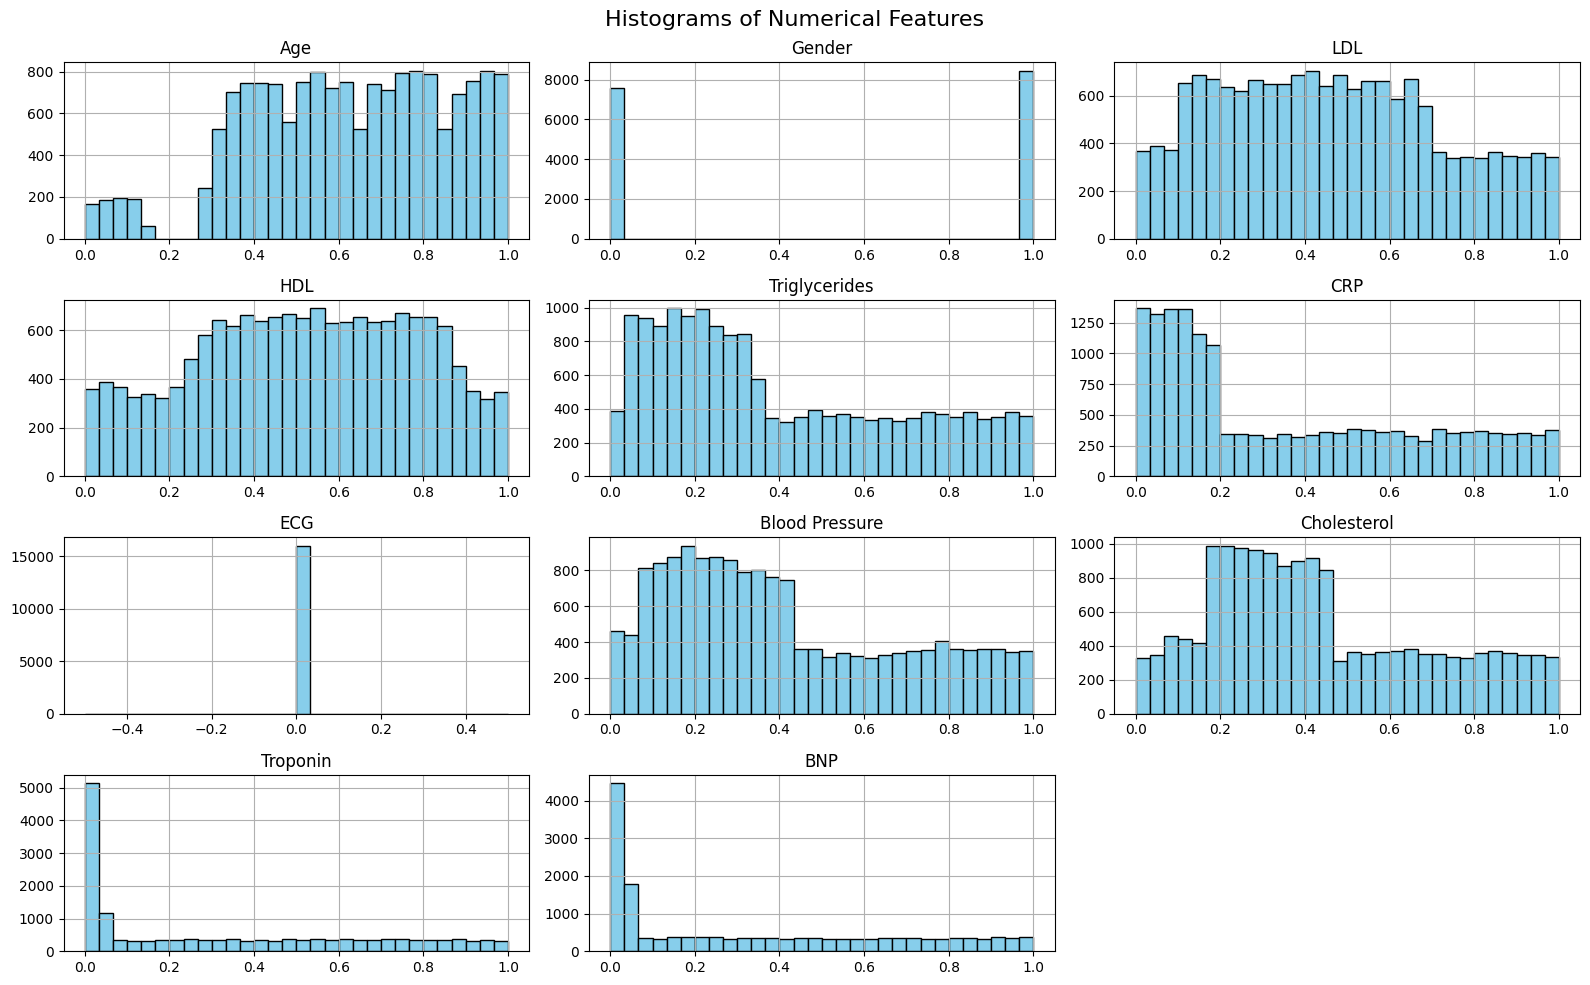

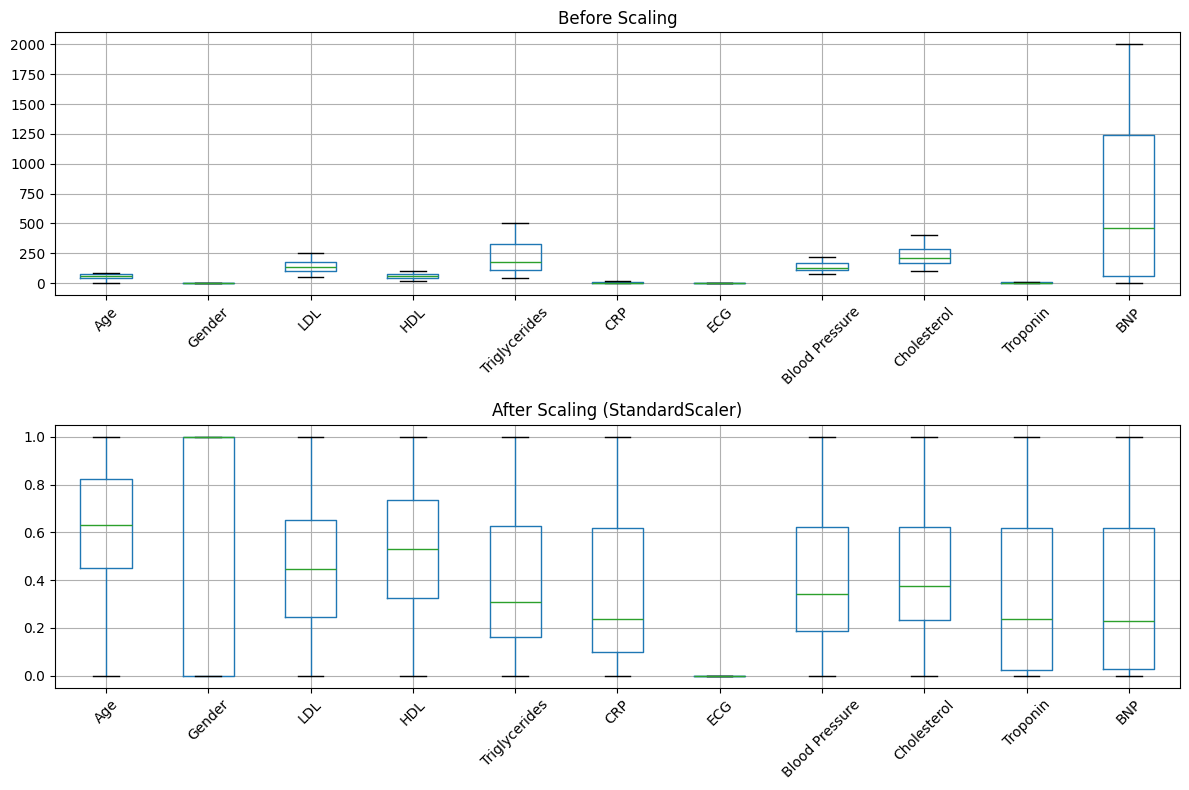

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled